In [1]:
from PosSelect_Functions_Old import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import wilcoxon
from scipy.optimize import curve_fit
from scipy.stats import fisher_exact

hfont = {'fontname':'Arial'}
plt.rcParams["font.family"] = "Arial"

#Code borrowed heavily from here: https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
plt.rcParams.update(
    {"text.usetex": False}
)

new_palette = {"Human":"#FF2C0C", "Chimp":"#0058FF", "Rhesus":"#9B00BA", "Marmoset":"#735D75"}


C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Read in data
v = pd.read_csv("../Myriad_RNA/Human_Referenced/TPM_Humreffed.txt", sep = "\t").set_index("gene")


In [7]:
#Set gene and extract data
gene = "IL32"
row = v.loc[gene]
out = []
for i in row.index:
    if "chp" in i:
        out.append([i.split("_")[1], "Chimp", row[i]])
    elif "hum" in i:
        out.append([i.split("_")[1], "Human", row[i]])
df = pd.DataFrame(out)
df.columns = ["Cell type", "Species", "TPM"]
#sns.swarmplot(data = df, x = "Cell type", hue = "Species", y = "TPM")

In [8]:
#Get means
out = []
for i in ["Human", "Chimp"]:
    for j in np.unique(df["Cell type"]):
        dff = df[(df["Species"] == i) & (df["Cell type"] == j)]
        out.append([j, i, np.mean(dff["TPM"])])
dfb = pd.DataFrame(out)
dfb.columns = ["Cell type", "Species", "TPM"]

-0.2
0.8
1.8
2.8
3.8
4.8
0.2000000000000001
1.2000000000000002
2.2
3.2
4.2
5.2
0.0
0.0


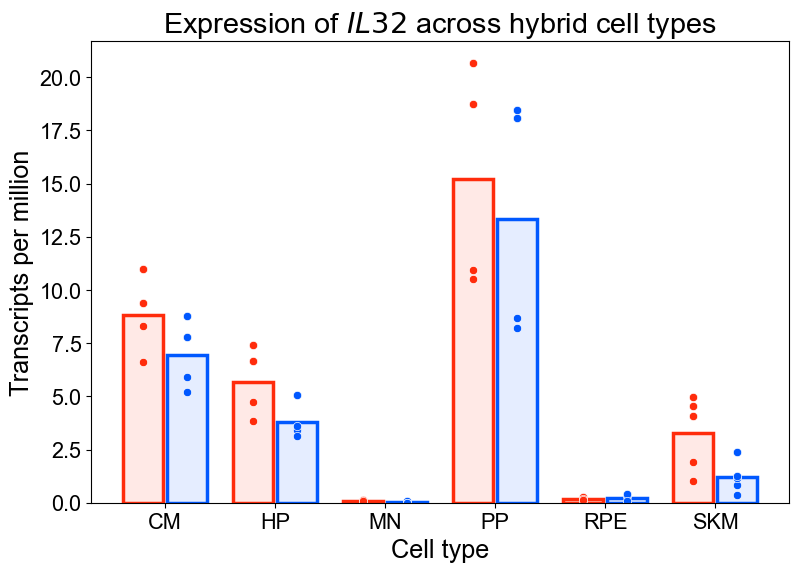

In [9]:
#sns.set_style("white")
new_palette = {"Human":"#FF2C0C", "Chimp":"#0058FF"}
fig, ax = plt.subplots(figsize = (9, 6))

#For TMPRSS2, mult = 1.5 and figsize = (9, 6)
#For NRROS and METTL4, mult = 1 and figsize = (6, 3)
t_ax = sns.barplot(data = dfb, x = "Cell type", y = "TPM", hue = "Species", errorbar=None, linewidth=2.5, edgecolor=".5", facecolor='#F2C91140', gap = 0.1, palette = {"Human":new_palette["Human"], "Chimp":new_palette["Chimp"]})
mult = 1.3
for patch in t_ax.patches:
    print(patch.get_x() + patch.get_width()/2)
c = 0
for patch in t_ax.patches:
    if c < 6:
        patch.set_edgecolor(new_palette["Human"])
        patch.set_facecolor(new_palette["Human"] + "1A")
    else:
        patch.set_edgecolor(new_palette["Chimp"])
        patch.set_facecolor(new_palette["Chimp"] + "1A")
    c += 1

cur = 0.4
for i in np.unique(df["Cell type"]):
    for j in np.unique(df["Species"]):
        dff = df[(df["Cell type"].isin([i])) & (df["Species"].isin([j]))]
        if j == "Human":
            x = np.repeat(cur - 0.6, dff.shape[0])
        elif j == "Chimp":
            x = np.repeat(cur - 0.2, dff.shape[0])
        
        sns.scatterplot(x = x, y = dff["TPM"], color = new_palette[j], marker = "o")
    cur += 1
    
plt.ylabel("Transcripts per million", size = 14*mult)
plt.xlabel("Cell type", size = 14*mult)

plt.title("Expression of $\it{" + gene + "}$ across hybrid cell types", size = 16*mult)
plt.legend([], [], frameon = False)
plt.xticks(size = 12*mult)
plt.yticks(size = 12*mult)

plt.show()

In [6]:
#Functions to read differential expression results
def read_de(file, gene, output, comp):
    de = pd.read_csv(file, sep = "\t")
    de = de.set_index("gene")
    try:
        de_gene = de.loc[gene]
        output.append([comp, round((float(de_gene["L2FC Humreffed"]) + float(de_gene["L2FC Chpreffed"]))/2, 5), float(de_gene["pvalue Humreffed"]), float(de_gene["padj Humreffed"])])
    except:
        pass
    return output

def read_de_tab(file, gene, output, comp):
    de = pd.read_csv(file, sep = "\t")
    de = de.set_index("gene")
    try:
        de_gene = de.loc[gene]
        ind = 1
        output.append([comp, round((float(de_gene["L2FC Humreffed"]) + float(de_gene["L2FC Chpreffed"]))/2, 5), float(de_gene["pvalue Humreffed"]), float(de_gene["padj Humreffed"])])
    except:
        ind = 0
    return output, ind

def table_Myriad(gene, types = ["CM", "RPE", "MN", "SKM", "PP", "HP"]):
    output = []
    tt = []
    for t in types:
        file = "../Myriad_RNA/" + t + "_Filtered.txt"
        a = read_de_tab(file, gene, output, "HumChp")
        output = a[0]
        if a[1]:
            tt.append(t)
    df = pd.DataFrame(output)
    df.columns = ["Comparison", "log2FoldChange", "p-value", "FDR"]
    df.index = tt
    #print(gene + " DESeq2 Information")
    #print("")
    #print(df)
    return df
table_Myriad(gene)

,Comparison,log2FoldChange,p-value,FDR
CM,HumChp,-0.02298,0.931744,0.963711
RPE,HumChp,-0.04087,0.894251,0.939976
MN,HumChp,-0.19928,0.029635,0.068524
SKM,HumChp,-0.02643,0.943912,0.981489
PP,HumChp,0.25141,0.000300,0.001121
HP,HumChp,0.21600,0.006870,0.017699


In [34]:
#Read in data to plot
v = pd.read_csv("../Ma_Sestan_Single_Cell/SLC32A1_Expression_ToPlot.txt", sep = "\t")
v = v[v["Cell Type"].isin(["PVALB", "SST_NPY", "SST_HGF", "SST", "VIP", "ADARB2_KCNG1", "PVALB_ChC", "LAMP5_RELN", "LAMP5_LHX6"])]
v.columns = ["CPM", "Species", "Cell type"]
v = v.sort_values("Cell type")

out = []
for i in np.unique(v["Cell type"]):
    for j in ["Human", "Chimp", "Rhesus", "Marmoset"]:
        dff = v[(v["Cell type"].isin([i])) & (v["Species"].isin([j]))]
        out.append([i, j, np.mean(dff["CPM"])])
dfp = pd.DataFrame(out)
dfp.columns = ["Cell type", "Species", "CPM"]

ValueError: The palette dictionary is missing keys: {'Rhesus', 'Marmoset'}

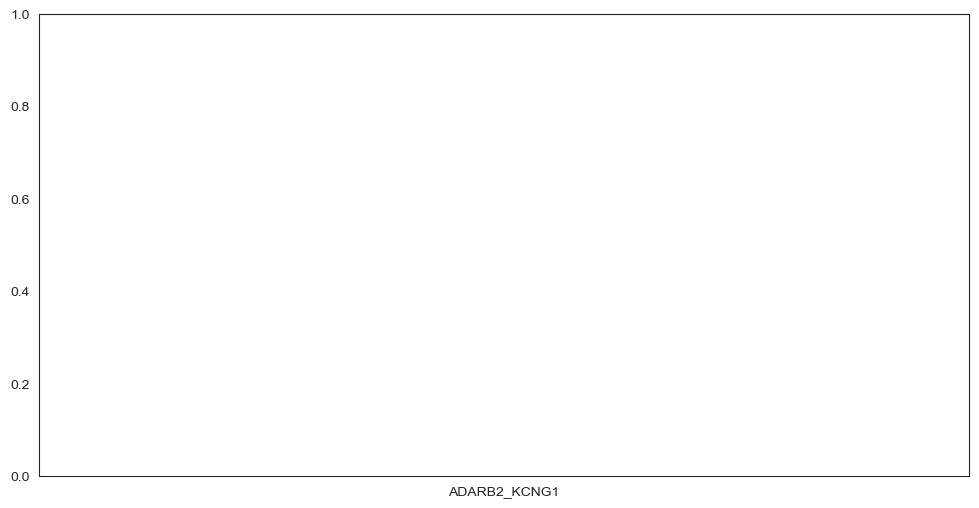

In [35]:
#Set gene name and create plot
gene = "CSMD1"
sns.set_style("white")
fig, ax = plt.subplots(figsize = (12, 6))

t_ax = sns.barplot(data = dfp, x = "Cell type", y = "CPM", hue = "Species", errorbar=None, linewidth=2.5, edgecolor=".5", facecolor='#F2C91140', gap = 0.1, palette = new_palette)

for patch in t_ax.patches:
    print(patch.get_x() + patch.get_width()/2)
c = 0
for patch in t_ax.patches:
    if c < 9:
        patch.set_edgecolor(new_palette["Human"])
        patch.set_facecolor(new_palette["Human"] + "1A")
    elif c < 18:
        patch.set_edgecolor(new_palette["Chimp"])
        patch.set_facecolor(new_palette["Chimp"] + "1A")
    elif c < 27:
        patch.set_edgecolor(new_palette["Rhesus"])
        patch.set_facecolor(new_palette["Rhesus"] + "1A")
    elif c < 36:
        patch.set_edgecolor(new_palette["Marmoset"])
        patch.set_facecolor(new_palette["Marmoset"] + "1A")
    c += 1

cur = 0.4
for i in np.unique(v["Cell type"]):
    for j in ["Human", "Chimp", "Rhesus", "Marmoset"]:
        dff = v[(v["Cell type"].isin([i])) & (v["Species"].isin([j]))]
        if j == "Human":
            x = np.repeat(cur - 0.7, dff.shape[0])
        elif j == "Chimp":
            x = np.repeat(cur - 0.5, dff.shape[0])
        elif j == "Rhesus":
            x = np.repeat(cur - 0.3, dff.shape[0])
        elif j == "Marmoset":
            x = np.repeat(cur - 0.1, dff.shape[0])
        sns.scatterplot(x = x, y = dff["CPM"], color = new_palette[j], marker = "o")
    cur += 1
    
plt.ylabel("Counts per million", size = 14*1.5)
plt.xlabel("Cell type", size = 14*1.5)

plt.title("Expression of $\it{" + gene + "}$ across\nadult cortical GABAergic neuron types", size = 16*1.5)
plt.legend([], [], frameon = False)
plt.xticks(size = 12*1.5, rotation = 90)
plt.yticks(size = 12*1.5)

plt.show()

-0.30000000000000004
0.7
1.7
2.7
3.7
4.7
5.7
6.7
7.7
8.7
-0.09999999999999998
0.9
1.9
2.9
3.9
4.9
5.9
6.9
7.9
8.9
0.09999999999999999
1.1
2.1
3.1
4.1
5.1
6.1
7.1
8.1
9.1
0.30000000000000004
1.3
2.3
3.3
4.3
5.3
6.3
7.3
8.3
9.3
0.0
0.0
0.0
0.0


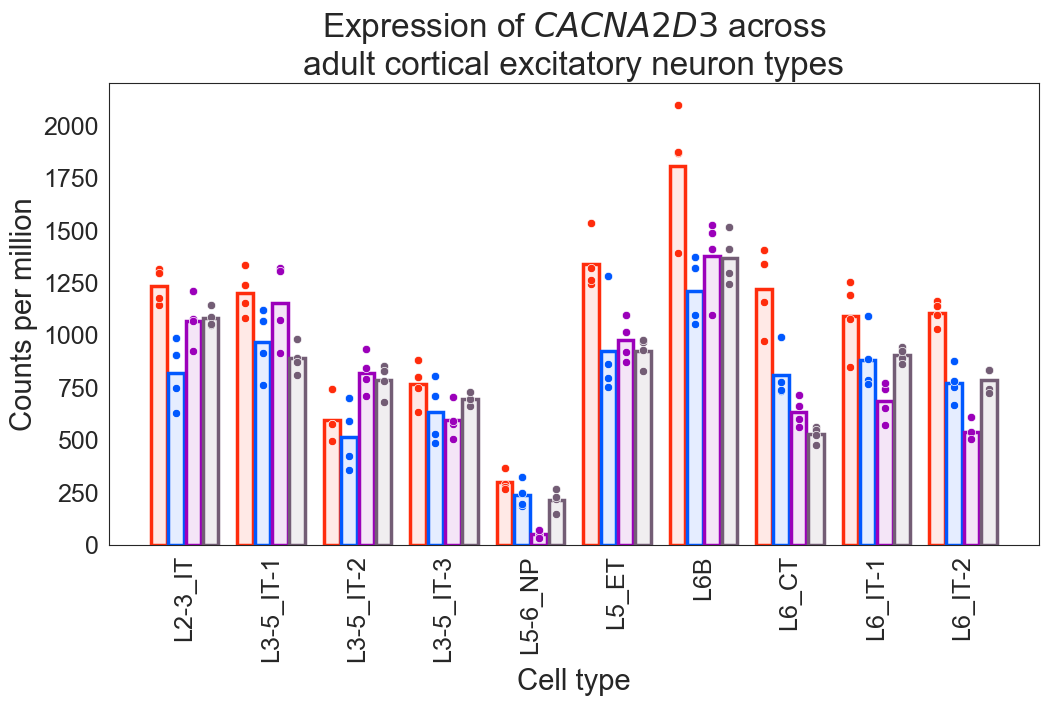

In [49]:
v = pd.read_csv("../Ma_Sestan_Single_Cell/CACNA2D3_ToPlot.txt", sep = "\t")
v = v[v["Cell Type"].isin(['L2-3_IT', 'L3-5_IT-1', 'L3-5_IT-2', 'L3-5_IT-3', 'L5-6_NP', 'L5_ET', 'L6B', 'L6_CT', 'L6_IT-1', 'L6_IT-2'])]
v.columns = ["CPM", "Species", "Cell type"]
v = v.sort_values("Cell type")

out = []
for i in np.unique(v["Cell type"]):
    for j in ["Human", "Chimp", "Rhesus", "Marmoset"]:
        dff = v[(v["Cell type"].isin([i])) & (v["Species"].isin([j]))]
        out.append([i, j, np.mean(dff["CPM"])])
dfp = pd.DataFrame(out)
dfp.columns = ["Cell type", "Species", "CPM"]

gene = "CACNA2D3"
sns.set_style("white")
fig, ax = plt.subplots(figsize = (12, 6))

t_ax = sns.barplot(data = dfp, x = "Cell type", y = "CPM", hue = "Species", errorbar=None, linewidth=2.5, edgecolor=".5", facecolor='#F2C91140', gap = 0.1, palette = new_palette)

for patch in t_ax.patches:
    print(patch.get_x() + patch.get_width()/2)
c = 0
for patch in t_ax.patches:
    if c < 10:
        patch.set_edgecolor(new_palette["Human"])
        patch.set_facecolor(new_palette["Human"] + "1A")
    elif c < 20:
        patch.set_edgecolor(new_palette["Chimp"])
        patch.set_facecolor(new_palette["Chimp"] + "1A")
    elif c < 30:
        patch.set_edgecolor(new_palette["Rhesus"])
        patch.set_facecolor(new_palette["Rhesus"] + "1A")
    elif c < 40:
        patch.set_edgecolor(new_palette["Marmoset"])
        patch.set_facecolor(new_palette["Marmoset"] + "1A")
    c += 1

cur = 0.4
for i in np.unique(v["Cell type"]):
    for j in ["Human", "Chimp", "Rhesus", "Marmoset"]:
        dff = v[(v["Cell type"].isin([i])) & (v["Species"].isin([j]))]
        if j == "Human":
            x = np.repeat(cur - 0.7, dff.shape[0])
        elif j == "Chimp":
            x = np.repeat(cur - 0.5, dff.shape[0])
        elif j == "Rhesus":
            x = np.repeat(cur - 0.3, dff.shape[0])
        elif j == "Marmoset":
            x = np.repeat(cur - 0.1, dff.shape[0])
        sns.scatterplot(x = x, y = dff["CPM"], color = new_palette[j], marker = "o")
    cur += 1
    
plt.ylabel("Counts per million", size = 14*1.5)
plt.xlabel("Cell type", size = 14*1.5)

plt.title("Expression of $\it{" + gene + "}$ across\nadult cortical excitatory neuron types", size = 16*1.5)
plt.legend([], [], frameon = False)
plt.xticks(size = 12*1.5, rotation = 90)
plt.yticks(size = 12*1.5)

plt.show()

In [11]:
def read_file(file, output, gene, t, species = "Chimp", h = False):
    tpm = pd.read_csv(file, sep = "\t")
    tpm_gene = tpm.loc[gene]
    if h:
        for index in tpm_gene.index:
            if "Human" in index or "human" in index:
                output.append([tpm_gene[index], "Human", t])
            elif species in index or species.lower() in index:
                output.append([tpm_gene[index], species, t])
            elif species == "Rhesus" and "Macaque" in index:
                output.append([tpm_gene[index], species, t])
    else:
        for index in tpm_gene.index:
            if species in index or species.lower() in index:
                output.append([tpm_gene[index], species, t])
            elif species == "Rhesus" and "Macaque" in index:
                output.append([tpm_gene[index], species, t])
    return output

def read_file_h(file, output, gene, t, species = "Chimp", h = False):
    tpm = pd.read_csv(file, sep = "\t")
    tpm_gene = tpm.loc[gene]
    if h:
        for index in tpm_gene.index:
            if "_ha" in index or "_hb" in index or "_hc" in index or "_hd" in index:
                output.append([tpm_gene[index], "Human", t])
    if species == "Chimp":
        for index in tpm_gene.index:
            if "_cb" in index or "_cc" in index or "_cd" in index:
                output.append([tpm_gene[index], "Chimp", t])
    if species == "Bonobo":
        for index in tpm_gene.index:
            if "_ba" in index or "_bb" in index or "_bc" in index:
                output.append([tpm_gene[index], "Bonobo", t])
    if species == "Rhesus":
        for index in tpm_gene.index:
            if "_ma" in index or "_mb" in index or "_mc" in index:
                output.append([tpm_gene[index], "Rhesus", t])
    return output

def read_file_p(file, output, gene, t, species = "Chimp", h = True):
    tpm = pd.read_csv(file, sep = "\t")
    tpm_gene = tpm.loc[gene]
    if h:
        for index in tpm_gene.index:
            if "H2" in index:
                output.append([tpm_gene[index], "Human", t])
            elif "C3" in index:
                output.append([tpm_gene[index], species, t])
    return output

def read_de(file, gene, output, comp):
    de = pd.read_csv(file, sep = "\t")
    de = de.set_index("Gene")
    de_gene = de.loc[gene]
    output.append([comp, round(float(de_gene["log2FoldChange"]), 5), float(de_gene["pvalue"]), float(de_gene["padj_mine"])])
    return output

def plot_AgoFra_2021_Hybrid(gene, times = ["iPSC", "D50", "D100", "D150", "D200"], ref = "chpr"):
    if ref == "humr":
        folder = "../Prime_DB_Expression/Agoglia_Fraser_2021/STAR/Hybrid_Humr/"
    else:
        folder = "../Prime_DB_Expression/Agoglia_Fraser_2021/STAR/Hybrid_Chpr/"
    skel = "Agoglia_Fraser_2021_DESeq2_HumChp_Hybrid_CS_D50_" + ref + "_tpm.txt"
    output = []
    for t in times:
        if t != "iPSC":
            file = folder + "/" + skel.replace("D50", t)
        else:
            file = folder + "/" + "Agoglia_Fraser_2021_DESeq2_HumChp_Hybrid_iPSC_" + ref + "_tpm.txt"
        output = read_file(file, output, gene, t, species = "Chimp", h = True)
    df = pd.DataFrame(output)
    df.columns = ["TPM", "Species", "Time since differentiation"]
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.swarmplot(x="Time since differentiation", y="TPM", hue = "Species", data=df, dodge = True, order = times, palette = new_palette)
    ax = sns.boxplot(x="Time since differentiation", y="TPM", hue = "Species", data=df, boxprops={'facecolor':'None'}, showfliers=False, order = times)
    plt.legend([],[], frameon=False)
    ax.set_xlabel("Time since differentiation")
    ax.set_title("Expression of " + gene)
    return ax, df

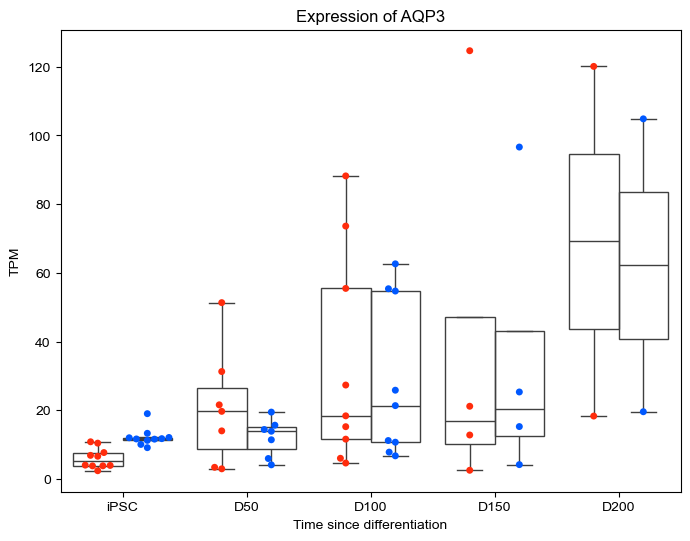

In [12]:
#Make preliminary plot for hybrid cortical organoids
gene = "AQP3"
ax, df = plot_AgoFra_2021_Hybrid(gene)

In [37]:
#Replace names
df["Time since differentiation"] = df["Time since differentiation"].replace("D150", "Day 150")
df["Time since differentiation"] = df["Time since differentiation"].replace("D50", "Day 50")
df["Time since differentiation"] = df["Time since differentiation"].replace("D100", "Day 100")
df["Time since differentiation"] = df["Time since differentiation"].replace("D200", "Day 200")

In [38]:
#Get means
out = []
for i in ["Human", "Chimp"]:
    for j in np.unique(df["Time since differentiation"]):
        dff = df[(df["Species"] == i) & (df["Time since differentiation"] == j)]
        out.append([j, i, np.mean(dff["TPM"])])
dfb = pd.DataFrame(out)
dfb.columns = ["Time since differentiation", "Species", "TPM"]

-0.2
0.8
1.8
2.8
3.8
0.2000000000000001
1.2000000000000002
2.2
3.2
4.2
0.0
0.0


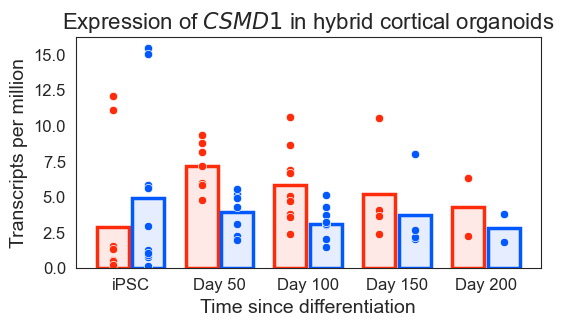

In [39]:
#Make plots
#sns.set_style("white")
new_palette = {"Human":"#FF2C0C", "Chimp":"#0058FF"}
fig, ax = plt.subplots(figsize = (6, 3))


t_ax = sns.barplot(data = dfb, x = "Time since differentiation", y = "TPM", order = ["iPSC", "Day 50", "Day 100", "Day 150", "Day 200"], hue = "Species", errorbar=None, linewidth=2.5, edgecolor=".5", facecolor='#F2C91140', gap = 0.1, palette = {"Human":new_palette["Human"], "Chimp":new_palette["Chimp"]})
mult = 1
for patch in t_ax.patches:
    print(patch.get_x() + patch.get_width()/2)
c = 0
for patch in t_ax.patches:
    if c < 5:
        patch.set_edgecolor(new_palette["Human"])
        patch.set_facecolor(new_palette["Human"] + "1A")
    else:
        patch.set_edgecolor(new_palette["Chimp"])
        patch.set_facecolor(new_palette["Chimp"] + "1A")
    c += 1

cur = 0.4
for i in ["iPSC", "Day 50", "Day 100", "Day 150", "Day 200"]:
    for j in np.unique(df["Species"]):
        dff = df[(df["Time since differentiation"].isin([i])) & (df["Species"].isin([j]))]
        if j == "Human":
            x = np.repeat(cur - 0.6, dff.shape[0])
        elif j == "Chimp":
            x = np.repeat(cur - 0.2, dff.shape[0])
        
        sns.scatterplot(x = x, y = dff["TPM"], color = new_palette[j], marker = "o")
    cur += 1
    
plt.ylabel("Transcripts per million", size = 14*mult)
plt.xlabel("Time since differentiation", size = 14*mult)

plt.title("Expression of $\it{" + gene + "}$ in hybrid cortical organoids", size = 16*mult)
plt.legend([], [], frameon = False)
plt.xticks(size = 12*mult)
plt.yticks(size = 12*mult)

plt.show()